In [1]:
import pandas as pd
import numpy as np
import os
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\gshik\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\gshik\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\gshik\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
customer_level_data = pd.read_csv('data/customer_level_features.csv', index_col=0)

In [4]:
customer_level_data.shape

(245453, 64)

In [5]:
customer_level_data.isnull().sum().sort_values()

customer_id                  0
month_1_sum                  0
month_2_sum                  0
month_3_sum                  0
month_4_sum                  0
                            ..
transmission_id_4356_sum     0
transmission_id_4996_sum     0
transmission_id_21124_sum    0
amount_paid_mean             0
is_returning_customer        0
Length: 64, dtype: int64

## Splitting data into Features and Labels

In [6]:
Y = pd.DataFrame(customer_level_data[['customer_id', 'is_returning_customer']])
X = customer_level_data.drop(['is_returning_customer'],axis = 1)

## Spliting data to train and test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 11)

## Removing Low variance features

In [8]:
print("\n")
print("----------- Removing Variables with low variance-------------")
print("\n")
model_data = X_train.drop(['customer_id'], axis=1)
feature_selector = VarianceThreshold(threshold=0)
feature_selector.fit(model_data)

Feat_Low_Var = []
for x in model_data.columns:
    if x not in model_data.columns[feature_selector.get_support()]:
        Feat_Low_Var.append(x)

if Feat_Low_Var == []:
    print('No feature with Low Variance')
else:
    print('Features with low variance are \n \n', Feat_Low_Var)

print("\n")
print("----------- Dropping 'platform_id_22295_sum', 'transmission_id_2020_sum'-------------")
print("\n")

X_train.drop(['platform_id_22295_sum', 'transmission_id_2020_sum'], axis=1, inplace=True)



----------- Removing Variables with low variance-------------


Features with low variance are 
 
 ['platform_id_22295_sum', 'transmission_id_2020_sum']


----------- Dropping 'platform_id_22295_sum', 'transmission_id_2020_sum'-------------




C:\Users\gshik\Anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Highly Correlated Features

In [9]:
print("\n")
print("----------- Following variable are Higly correlated-------------")
print("\n")

# Since it is no linear classifier a high threshold of pearson's correlation is chosen
def print_highly_correlated(df, threshold):
    """Prints highly correlated features pairs in the data frame (helpful for feature engineering)"""
    corr_df = df.corr() # get correlations
    correlated_features = np.where(np.abs(corr_df) > threshold) # select ones above the abs threshold
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value
    
    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        for v, i, j in s_corr_list:
            cols = df.columns
            print ("%s and %s = %.3f" % (corr_df.index[i], corr_df.columns[j], v))

print_highly_correlated(X_train.drop(['customer_id'], axis=1), threshold=0.9)

print("\n")



----------- Following variable are Higly correlated-------------


year_2016_sum and customer_order_rank_max = 0.935
customer_order_rank_max and amount_paid_sum = 0.933
weekend_sum and dayofweek_num_6_sum = 0.933




Dropping Correlated Variables:

    1.Based on correlation analysis and also on variable understanding we know that:
        'weekend_sum' and 'dayofweek_num_6_sum'
        'year_2016_sum' and 'customer_order_rank_max' 
    capture same information so it makes sense to drop one of them.
    
    2.Since above variables are highly correlated(~0.94), together they won't add any additional predictive power. Moreover dropping one of them would result in more genralised model.
    
    3.We further need do Variable Importance Analysis to decide which features to drop from these combinations
    

## Variable Importance using Random Forest Classifier



-------- Feature Importance based on Standard Paramters of Random Forest Classifier-------


                feature_names    importance
58            amount_paid_sum  1.143767e-01
59           amount_paid_mean  9.578208e-02
30              year_2017_sum  6.436438e-02
52    customer_order_rank_max  4.817905e-02
51             order_hour_min  4.781605e-02
50             order_hour_max  4.499535e-02
29              year_2016_sum  4.121403e-02
32                month_2_sum  3.079928e-02
24   transmission_id_4356_sum  2.965769e-02
27                weekend_sum  2.745442e-02
2         payment_id_1619_sum  2.522034e-02
57          delivery_fee_mean  2.354666e-02
56           delivery_fee_sum  2.302971e-02
49        dayofweek_num_6_sum  1.974583e-02
21   transmission_id_4228_sum  1.938199e-02
23   transmission_id_4324_sum  1.767299e-02
8       platform_id_29463_sum  1.673711e-02
3         payment_id_1779_sum  1.668488e-02
31                month_1_sum  1.623276e-02
47        dayofweek_num_4

<AxesSubplot:>

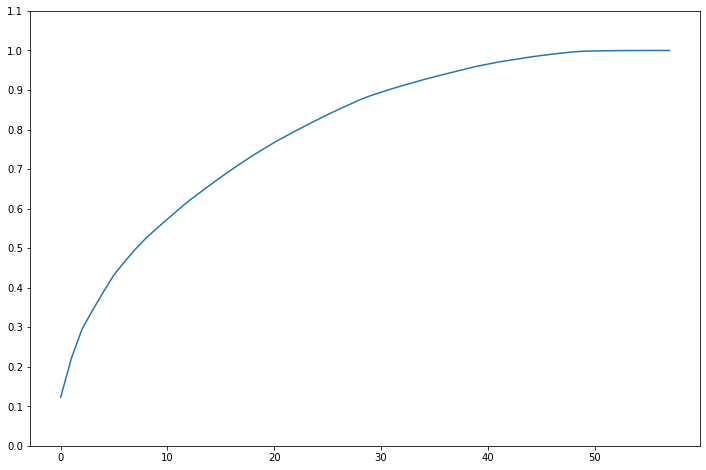

In [10]:
print("\n")
print("-------- Feature Importance based on Standard Paramters of Random Forest Classifier-------")
print("\n")
model = RandomForestClassifier()
model.fit(X_train.drop(['customer_id'], axis=1), y_train['is_returning_customer'])
imp_features_df = pd.DataFrame({'feature_names':X_train.drop(['customer_id'], axis=1).columns,\
                                'importance':model.feature_importances_})
imp_features_df.sort_values('importance',ascending=False,inplace=True)
print(imp_features_df)


print("\n")
print("""--------- Feature Importance based on standard paramters of Random Forest Classifier
                    after removing i.e. 'dayofweek_num_6_sum' & 'customer_order_rank_max'--------""")
print("\n")

model2 = RandomForestClassifier()
model2.fit(X_train.drop(['customer_id', 'dayofweek_num_6_sum', 'customer_order_rank_max'], axis=1),\
           y_train['is_returning_customer'])
imp_features_df2 = pd.DataFrame({'feature_names':X_train.drop(['customer_id', 'dayofweek_num_6_sum',\
                    'customer_order_rank_max'], axis=1).columns,'importance':model2.feature_importances_})
imp_features_df2 = imp_features_df2.sort_values('importance',ascending=False).reset_index(drop=True)
imp_features_df2['cum_importance'] = imp_features_df2.importance.cumsum()
print(imp_features_df2)

imp_features_df2.cum_importance.plot(figsize = (12, 8), yticks = np.arange(0, 1.2, 0.1))

## Feature Reduction using Variable Importance

In [13]:
print("\n")
print("-----From above table and plot we take Variables capturing 95% of Cumulative Importance-----")
print("\n")
features = imp_features_df2[imp_features_df2.cum_importance <=0.95]['feature_names']
features[31]='customer_id'
X_train = X_train[features]
X_test = X_test[features]

print("\n")
print("----------- Shape of train Dataset after Feature Reduction-------------")
print("\n")
print(X_train.shape)

print("\n")
print("----------- Shape of test Dataset after Feature Reduction-------------")
print("\n")
print(X_test.shape)



-----From above table and plot we take Variables capturing 95% of Cumulative Importance-----




----------- Shape of train Dataset after Feature Reduction-------------


(171817, 38)


----------- Shape of test Dataset after Feature Reduction-------------


(73636, 38)


C:\Users\gshik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
print("\n")
print("----------- Writing Modelling Datasets-------------")
print("\n")


Training_data =X_train.merge(y_train, how='inner', on = 'customer_id')
Testing_data = X_test.merge(y_test, how='inner', on = 'customer_id')

print("\n")
print("----------- Shape of train Dataset-------------")
print("\n")
print(Training_data.shape)

print("\n")
print("----------- Shape of test Dataset-------------")
print("\n")
print(Testing_data.shape)

Training_data.to_csv('data/Train.csv')
Testing_data.to_csv('data/Test.csv')



----------- Writing Modelling Datasets-------------




----------- Shape of train Dataset-------------


(171817, 39)


----------- Shape of test Dataset-------------


(73636, 39)
